<a href="https://colab.research.google.com/github/Richard-Shimada/Project-2/blob/main/Project_2_Part_4_V3_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [308]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, classification_report)
from  matplotlib.ticker import PercentFormatter
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from google.colab import drive
drive.mount('/content/drive')

#https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

base_df = pd.read_csv('/content/drive/MyDrive/Coding Dojo 2022/07 Week 7: Classification Models/heart-failure-data.csv')
df = base_df.copy()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [309]:
## definining evaluate_classification function here for classification model metrics

def evaluate_classification(preds, actual, label="Test Data"):
  #test_preds = lgr_pipe.predict(X_test)

   ## Print classification report for the test data (and make it pretty!)
  print('---'*20)
  print(f"[i] CLASSIFICATION REPORT FOR: {label}")
  print('---'*20)
  # print the classiffication report from the test data
  print(classification_report(actual, preds))

  fig, axes = plt.subplots(1,2, figsize=(15,5))

  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(actual, preds, 
               normalize='true', cmap='Greens',
               ax = axes[0]);

  RocCurveDisplay.from_predictions(preds, actual, ax=axes[1])
  plt.show()

In [310]:
#No duplicate values
df.duplicated().sum()

0

In [311]:
#No missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [313]:
#Checking for any odd values in categorical columns, none found!
print(df['Sex'].unique())
print(df['ChestPainType'].unique())
print(df['FastingBS'].unique())
print(df['RestingECG'].unique())
print(df['ExerciseAngina'].unique())
print(df['ST_Slope'].unique())
print(df['HeartDisease'].unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
[0 1]
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']
[0 1]


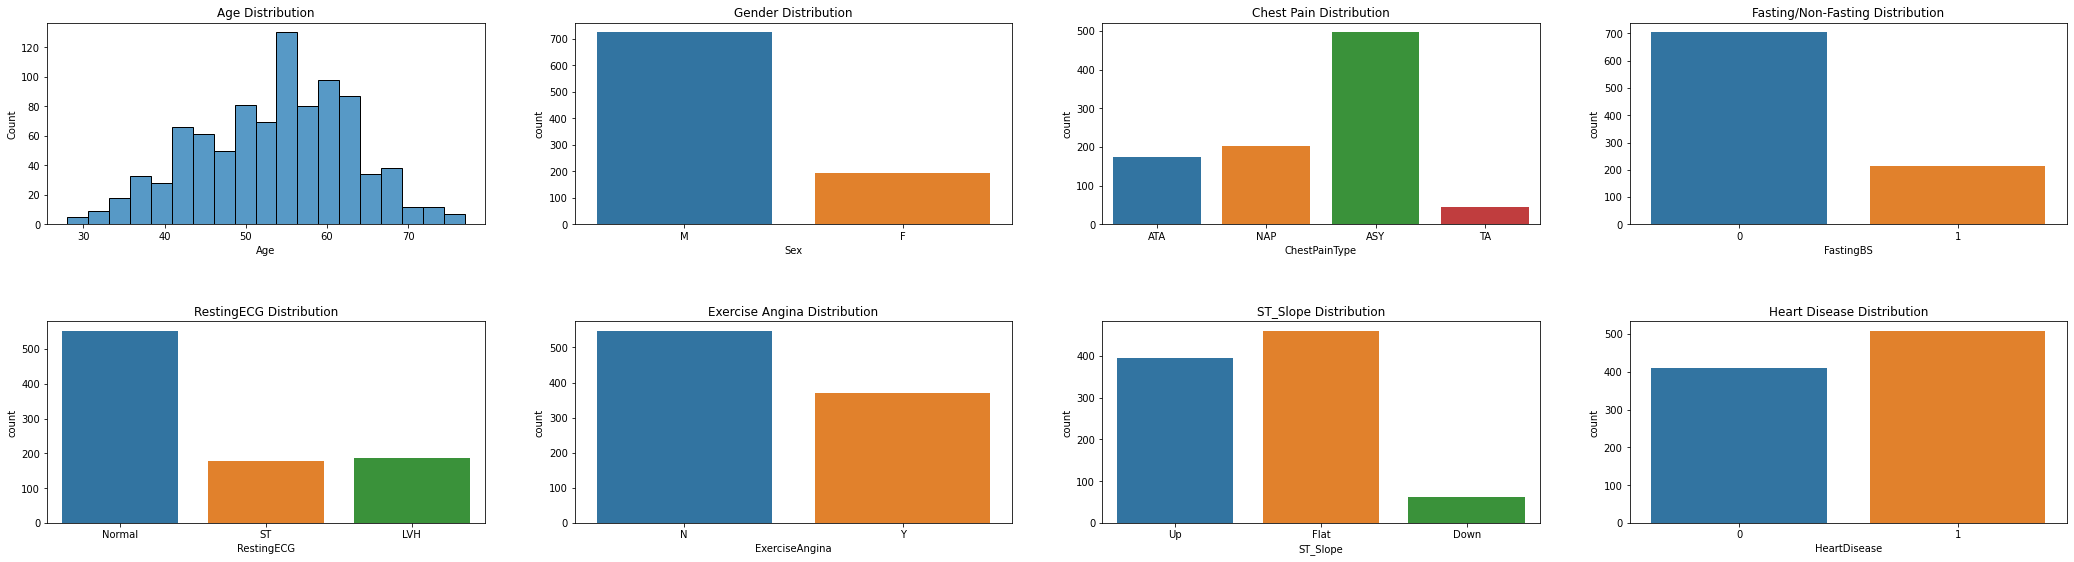

In [314]:
#Histograms on categorical variables

fig, axes = plt.subplots(2,4, figsize=(30,9))

sns.histplot(data=df,x='Age',ax=axes[0][0]).set(title='Age Distribution')
sns.countplot(data=df,x='Sex',ax=axes[0][1]).set(title='Gender Distribution')
sns.countplot(data=df,x='ChestPainType',ax=axes[0][2]).set(title='Chest Pain Distribution')
sns.countplot(data=df,x='FastingBS',ax=axes[0][3]).set(title='Fasting/Non-Fasting Distribution')
sns.countplot(data=df,x='RestingECG',ax=axes[1][0]).set(title='RestingECG Distribution')
sns.countplot(data=df,x='ExerciseAngina',ax=axes[1][1]).set(title='Exercise Angina Distribution')
sns.countplot(data=df,x='ST_Slope',ax=axes[1][2]).set(title='ST_Slope Distribution')
sns.countplot(data=df,x='HeartDisease',ax=axes[1][3]).set(title='Heart Disease Distribution')

fig.tight_layout(pad=5.0)

1. Most people in this study are 40 to 70 years of age and Male.
2. The dataset is mostly balanced, with more people having HeartDisease versus not.

In [315]:
#Fasting BS should really be OHE, your readings will be different but one is not more intense/severe than the other so changing numbers to text to do OHE
df['FastingBS'].replace({1:'Fasting', 0:'Non-Fasting'}, inplace=True)

#If you have ExerciseAngina that's bad, so will ordinal encode
df['ExerciseAngina'].replace({'N':0, 'Y':1}, inplace=True)

1. ChestPainType/ECG - these probably should be ordinal encoded as Normal/Asymptomatic seem better than the other conditions but I'm not a doctor so don't know which conditions are worse than each other so will one hot encode.
2. Sex and ST_slope are straightforward and should be one hot encoded.

In [316]:
#For Oldpeak and FastingBS - 0 values are appropriate
#Impute 0s to NaN for imputing in next step

df['RestingBP'].replace(0,np.nan,inplace=True)
df['Cholesterol'].replace(0,np.nan,inplace=True)

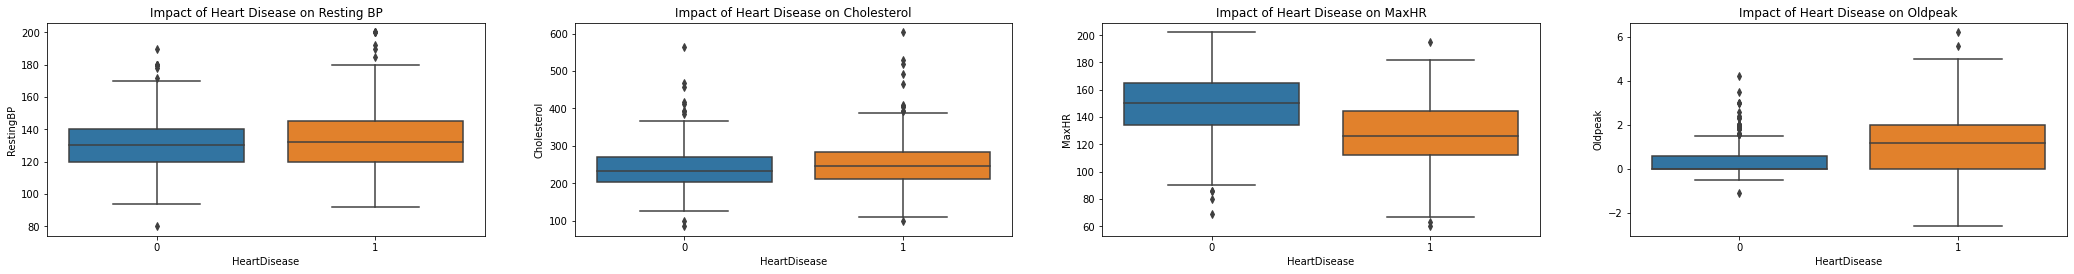

In [317]:
#BP, Cholesterol, maxHR,old peak boxplots
fig, axes = plt.subplots(1,4, figsize=(30,5))
sns.boxplot(data = df, x='HeartDisease',y='RestingBP',ax=axes[0]).set(title='Impact of Heart Disease on Resting BP')
sns.boxplot(data = df, x='HeartDisease',y='Cholesterol',ax=axes[1]).set(title='Impact of Heart Disease on Cholesterol')
sns.boxplot(data = df, x='HeartDisease',y='MaxHR',ax=axes[2]).set(title='Impact of Heart Disease on MaxHR')
sns.boxplot(data = df, x='HeartDisease',y='Oldpeak',ax=axes[3]).set(title='Impact of Heart Disease on Oldpeak')

fig.tight_layout(pad=5.0)

1. Resting BP and Cholesterol are similar for those with and without Heart Disease.
2. Those with Heart disease tend to have a lower MaxHR and higher/wider Oldpeak values.

In [318]:
#The 0 values for BP/Cholesterol need to be imputed

#df.loc[df['RestingBP']==0]
#df.loc[df['Cholesterol'] ==0]

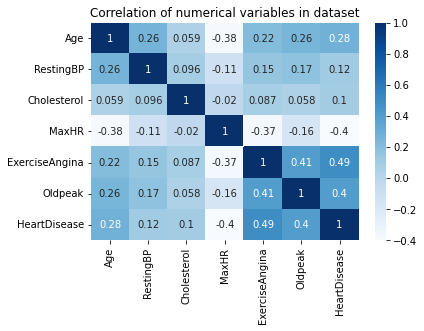

In [319]:
corr = df.corr()
sns.heatmap(corr,cmap='Blues',annot=True).set(title='Correlation of numerical variables in dataset');

The numeric variables don't show strong correlation with one another.

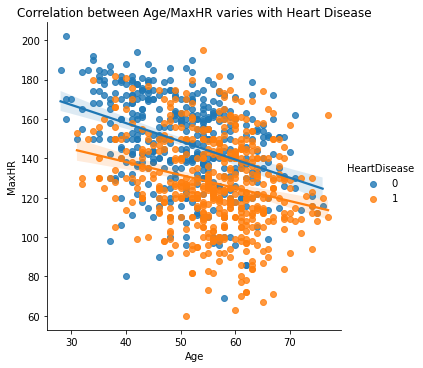

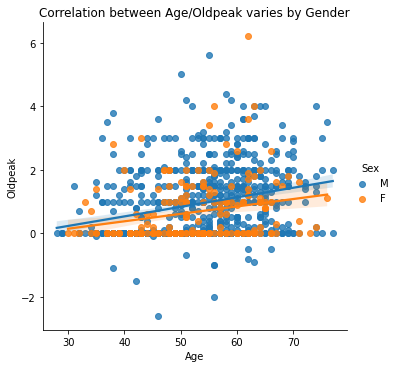

In [320]:
sns.lmplot(data = df,x = 'Age',y = 'MaxHR',hue ='HeartDisease').set(title='Correlation between Age/MaxHR varies with Heart Disease');
sns.lmplot(data = df,x = 'Age',y = 'Oldpeak',hue ='Sex').set(title='Correlation between Age/Oldpeak varies by Gender');

1. Age appears to be negatively correlated with MaxHR. The MaxHR for someone with Heart Disease is lower, all else equal.
2. Old peak appears to increase with Age.This relationship holds for Males and Females, with Males typically having higher Oldpeak values.

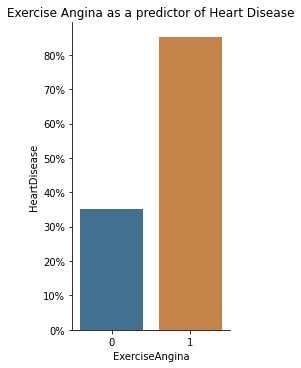

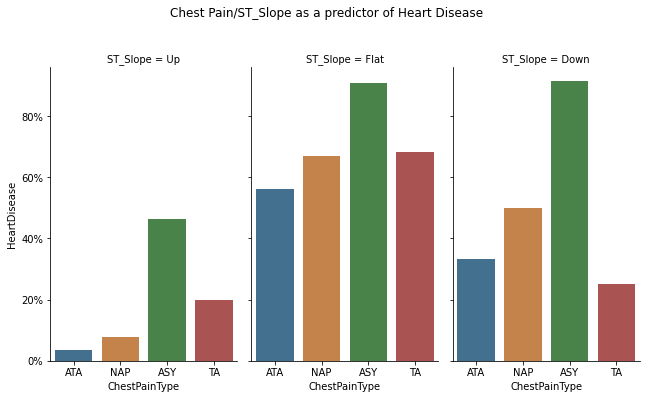

In [321]:
g = sns.catplot(x="ExerciseAngina", y="HeartDisease", data=df, saturation=.5, kind="bar", ci=None, aspect=.6).set(title='Exercise Angina as a predictor of Heart Disease');

#https://stackoverflow.com/questions/52512790/python-seaborn-catplot-how-do-i-change-the-y-axis-scale-to-percentage

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

print('\n')

h = sns.catplot(x="ChestPainType", y="HeartDisease", col="ST_Slope",
                 data=df, saturation=.5,
                 kind="bar", ci=None, aspect=.6);

plt.suptitle('Chest Pain/ST_Slope as a predictor of Heart Disease', y=1.1)

for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

1. ExerciseAngina is a strong indiciator of Heart Disease. When this condition is present, it is highly indicative of Heart Disease as well.
2. ST_Slope values of Flat/Down are more telling in terms of Heart Disease, as well as ChestPainType of ASY.


In [322]:
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

In [323]:
#Split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [324]:
#Create preprocessing pipeline. 
#Imputing values based on histogram/countplot output above
#Ordinal encoding has already been applied in previous steps, so scaling and one hot encoding here

cat_columns = make_column_selector(dtype_include='object')
num_columns = make_column_selector(dtype_include='number')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

cat_tuple = (cat_pipe, cat_columns)
num_tuple = (num_pipe, num_columns)

preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f728cc14650>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f728cc14ad0>)])

In [325]:
#quick check of processed data
X_train_processed = preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)

0 missing values in training data
0 missing values in testing data


Shape of X_train: (688, 11)
Shape of X_test: (230, 11)


All data in X_train_processed are float64
All data in X_test_processed are float64


In [326]:
#categorical models tested - KNN, Logistic Regression, Decision tree, XGBoost, LGBM
tree_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))
tree_pipe.fit(X_train,y_train)
tree_preds = tree_pipe.predict(X_test)

knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
knn_pipe.fit(X_train,y_train)
knn_preds = knn_pipe.predict(X_test)

LGBM_pipe = make_pipeline(preprocessor, LGBMClassifier(random_state=42))
LGBM_pipe.fit(X_train,y_train)
LGBM_preds = LGBM_pipe.predict(X_test)

log_reg_pipe = make_pipeline(preprocessor, LogisticRegression(random_state=42))
log_reg_pipe.fit(X_train,y_train)
log_reg_preds = log_reg_pipe.predict(X_test)

XGB_pipe = make_pipeline(preprocessor, XGBClassifier(random_state=42))
XGB_pipe.fit(X_train,y_train)
XGB_preds = XGB_pipe.predict(X_test)

gb_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=42))
gb_pipe.fit(X_train,y_train)
gb_preds = gb_pipe.predict(X_test)

Model metrics sorted below by ascending accuracy - will tune best performing gradient boosting model (XGB) and best performing non gradient boosting model (Logistic Regression model).  

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Decision Tree metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.89      0.79        98
           1       0.90      0.74      0.81       132

    accuracy                           0.80       230
   macro avg       0.81      0.82      0.80       230
weighted avg       0.82      0.80      0.81       230



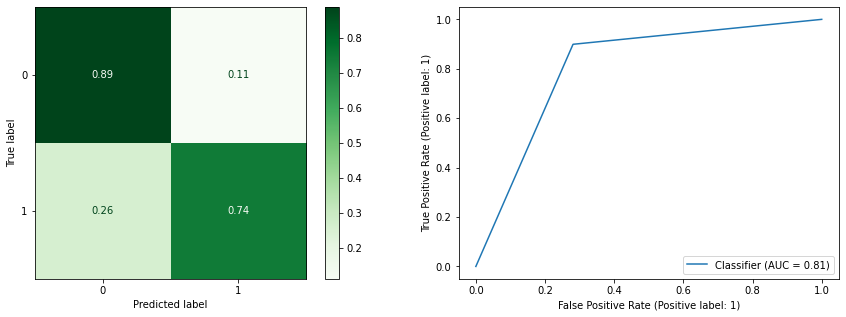

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: KNN metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        98
           1       0.88      0.86      0.87       132

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.86      0.86       230



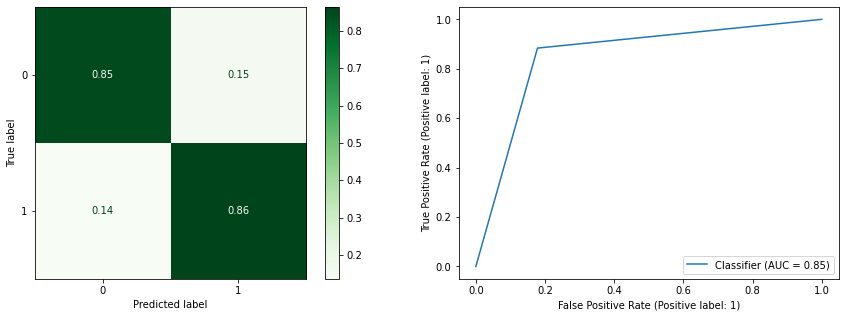

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: LGBM boosting metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        98
           1       0.91      0.86      0.89       132

    accuracy                           0.87       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.87      0.87       230



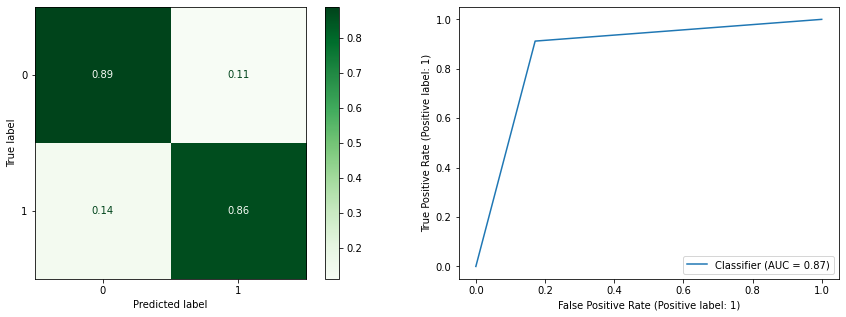

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Logistic Regression metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



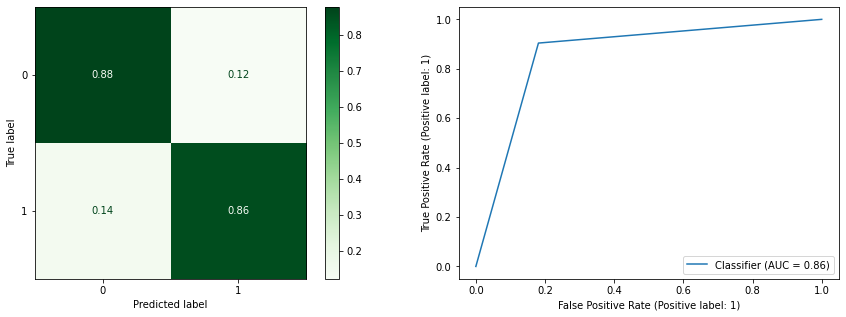

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Gradient boosting metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        98
           1       0.93      0.86      0.89       132

    accuracy                           0.88       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.89      0.88      0.88       230



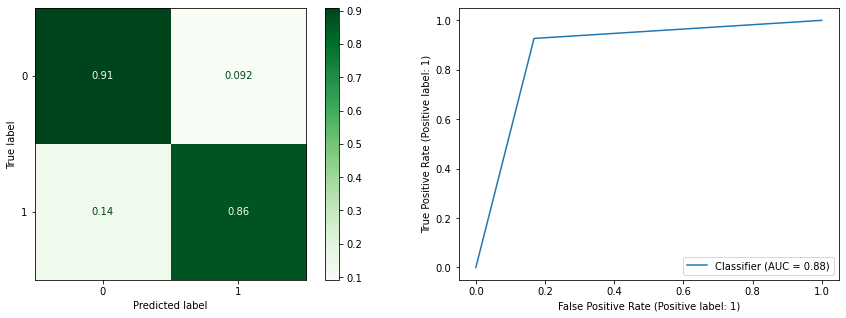

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGB metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        98
           1       0.92      0.89      0.90       132

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



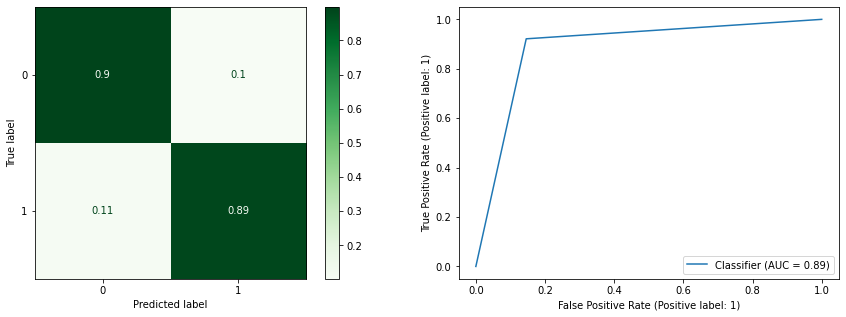

None


In [327]:
print(evaluate_classification(tree_preds,y_test,label = 'Decision Tree metrics'))
print(evaluate_classification(knn_preds,y_test,label = 'KNN metrics'))
print(evaluate_classification(LGBM_preds,y_test, label = 'LGBM boosting metrics'))
print(evaluate_classification(log_reg_preds,y_test,label = 'Logistic Regression metrics'))
print(evaluate_classification(gb_preds,y_test, label = 'Gradient boosting metrics'))
print(evaluate_classification(XGB_preds,y_test, label = 'XGB metrics'))

Best Logistic Regression Parameters:
{'logisticregression__C': 0.085, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Accuracy of best Logistic Regression model is: 0.8652173913043478


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Logistic Regression metrics - baseline
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



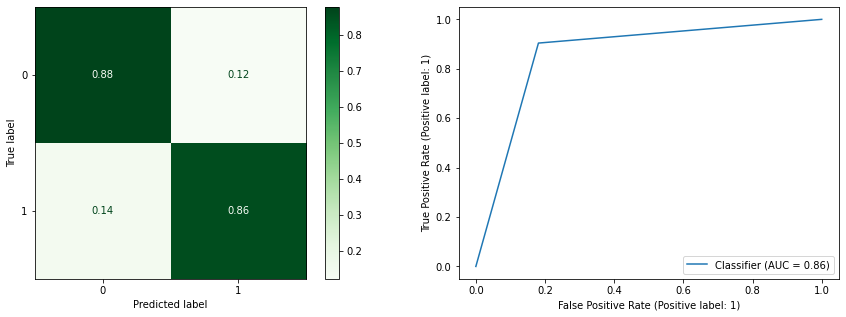

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Logistic Regression metrics - Tuned
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



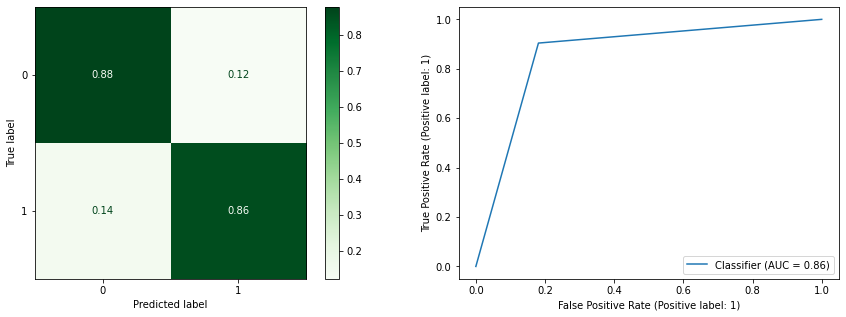

None
CPU times: user 3.69 s, sys: 139 ms, total: 3.83 s
Wall time: 3.69 s


In [328]:
%%time
#use grid search to optimize Logistic Regression Classifier
log_reg_param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01,0.06,0.07, 0.08, 0.085,0.09,0.1, 1, 10, 100, 1000],
  'logisticregression__solver': ['liblinear'],
  'logisticregression__penalty': ['l1','l2']}

log_reg_gs = GridSearchCV(log_reg_pipe, log_reg_param_grid)

log_reg_gs.fit(X_train, y_train)
print('Best Logistic Regression Parameters:')
print(log_reg_gs.best_params_)
best_log_reg_pipe = log_reg_gs.best_estimator_
print(f'Accuracy of best Logistic Regression model is: {best_log_reg_pipe.score(X_test, y_test)}')
print('\n')

#Save predictions to run through evaluate_classification function
log_reg_best_params_train_pred = best_log_reg_pipe.predict(X_train)
log_reg_best_params_test_pred = best_log_reg_pipe.predict(X_test)

print(evaluate_classification(log_reg_preds,y_test,label = 'Logistic Regression metrics - baseline'))
print(evaluate_classification(log_reg_best_params_test_pred,y_test,label = 'Logistic Regression metrics - Tuned'))

After tuning the Logistic Regression model, overall metrics remain unchanged from the baseline model.

Best Gradient Boosting Parameters:
{'xgbclassifier__learning_rate': 0.09, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 90}
Accuracy of best XGB boosting model is: 0.8869565217391304


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost metrics
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        98
           1       0.92      0.89      0.90       132

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



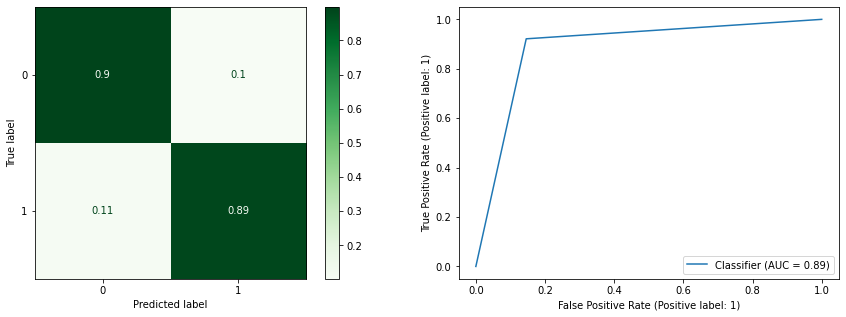

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost metrics - Tuned
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        98
           1       0.92      0.88      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



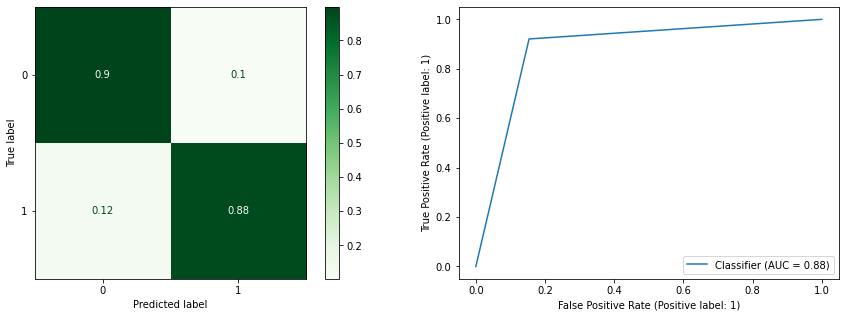

None
CPU times: user 16.8 s, sys: 186 ms, total: 17 s
Wall time: 16.9 s


In [329]:
%%time
#use grid search to optimize gradient boosting model
XGB_param_grid = {'xgbclassifier__max_depth': [2,3,4],
          'xgbclassifier__learning_rate': [.08, .09, .1],
          'xgbclassifier__n_estimators': [20,75,90,120,175]}

XGB_pipe_gs = GridSearchCV(XGB_pipe, XGB_param_grid)

XGB_pipe_gs.fit(X_train, y_train)
print('Best Gradient Boosting Parameters:')
print(XGB_pipe_gs.best_params_)
best_XGB_pipe = XGB_pipe_gs.best_estimator_
print(f'Accuracy of best XGB boosting model is: {best_XGB_pipe.score(X_test, y_test)}')
print('\n')

#Save predictions to run through evaluate_classification function
XGB_best_params_train_pred = best_XGB_pipe.predict(X_train)
XGB_best_params_test_pred = best_XGB_pipe.predict(X_test)

print(evaluate_classification(XGB_preds,y_test, label = 'XGBoost metrics'))
print(evaluate_classification(XGB_best_params_test_pred ,y_test,label = 'XGBoost metrics - Tuned'))

After tuning the XGBoost model, overall accuracy remains unchanged while AUC decreased slightly.  For the 1 class precision remains unchanged but recall decreased slightly. For the 0 class both precision and recall are unchanged.

In [330]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,Non-Fasting,Normal,172,0,0.0,Up,0
1,49,F,NAP,160.0,180.0,Non-Fasting,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130.0,283.0,Non-Fasting,ST,98,0,0.0,Up,0
3,48,F,ASY,138.0,214.0,Non-Fasting,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150.0,195.0,Non-Fasting,Normal,122,0,0.0,Up,0


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       917 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


In [332]:
#Making a copy of the modified data frame PRIOR to preprocessing to do some feature engineering.
engineered_df = df.copy()
engineered_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,Non-Fasting,Normal,172,0,0.0,Up,0
1,49,F,NAP,160.0,180.0,Non-Fasting,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130.0,283.0,Non-Fasting,ST,98,0,0.0,Up,0
3,48,F,ASY,138.0,214.0,Non-Fasting,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150.0,195.0,Non-Fasting,Normal,122,0,0.0,Up,0


1. Good resting BP is less than 120 mm Hg systolic/80 mm Hg diastolic.
2. LDL is bad, should be less than 200. HDL is good, 40 or above. (Cholesterol field has too many 0 values so will leave as-is instead of applying feature engineering and risking incorrect classification).

In [333]:
#Using above guidelines, will update RestingBP values to High/Normal. 
engineered_df['RestingBP'] = engineered_df['RestingBP'].apply(lambda x: 'High' if x > 120 else 'Normal')

#https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm#:~:text=You%20can%20estimate%20your%20maximum,beats%20per%20minute%20(bpm).
#Create field to measure variance from estimated MaxHR and actual MaxHR
engineered_df['MaxHR_variance'] = (220 - df['Age']) - df['MaxHR']

engineered_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,MaxHR_variance
0,40,M,ATA,High,289.0,Non-Fasting,Normal,172,0,0.0,Up,0,8
1,49,F,NAP,High,180.0,Non-Fasting,Normal,156,0,1.0,Flat,1,15
2,37,M,ATA,High,283.0,Non-Fasting,ST,98,0,0.0,Up,0,85
3,48,F,ASY,High,214.0,Non-Fasting,Normal,108,1,1.5,Flat,1,64
4,54,M,NAP,High,195.0,Non-Fasting,Normal,122,0,0.0,Up,0,44


In [334]:
X2 = engineered_df.drop(columns='HeartDisease')
y2 = engineered_df['HeartDisease']

X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,random_state=42)

Accuracy of best Gradient boosting model is: 0.8826086956521739


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost metrics - Tuned
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        98
           1       0.92      0.88      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



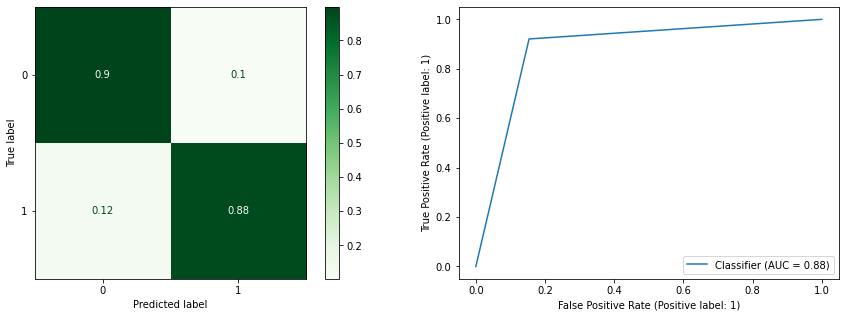

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: XGBoost metrics - Tuned + Feature engineering
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        98
           1       0.93      0.86      0.89       132

    accuracy                           0.88       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.89      0.88      0.88       230



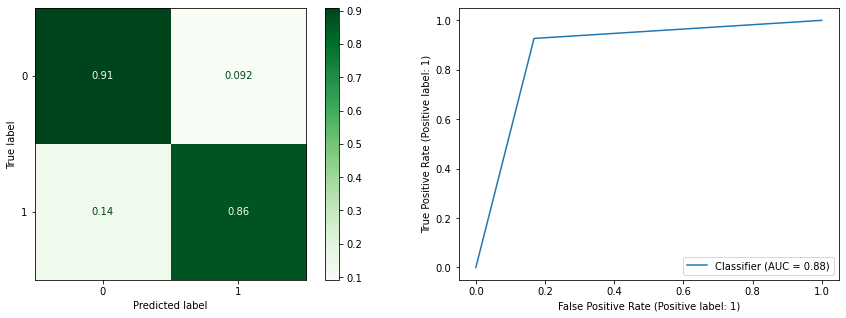

None
CPU times: user 848 ms, sys: 21.2 ms, total: 870 ms
Wall time: 881 ms


In [335]:
%%time
best_XGB_pipe.fit(X2_train, y2_train)
print(f'Accuracy of best Gradient boosting model is: {best_XGB_pipe.score(X2_test, y2_test)}')
print('\n')

#Save predictions to run through evaluate_classification function
XGB2_best_params_train_pred = best_XGB_pipe.predict(X2_train)
XGB2_best_params_test_pred = best_XGB_pipe.predict(X2_test)

print(evaluate_classification(XGB_best_params_test_pred ,y_test,label = 'XGBoost metrics - Tuned'))
print(evaluate_classification(XGB2_best_params_test_pred ,y2_test,label = 'XGBoost metrics - Tuned + Feature engineering'))

After applying feature engineering to the dataset used in the XGBoost model, AUC remains unchanged while accuracy decreased. For the 0 class, precision decreased but recall increased. For the 1 class the opposite is true - precision increased but recall decreased.

Accuracy of best Gradient boosting model is: 0.8652173913043478


------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Logistic Regression metrics - Tuned
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



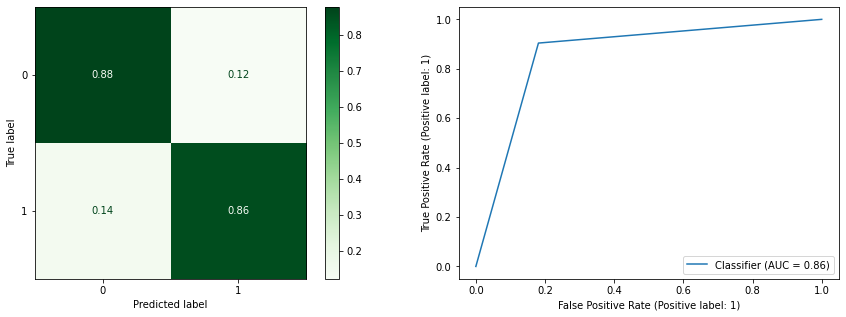

None
------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Logistic Regression metrics - Tuned + Feature engineering
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



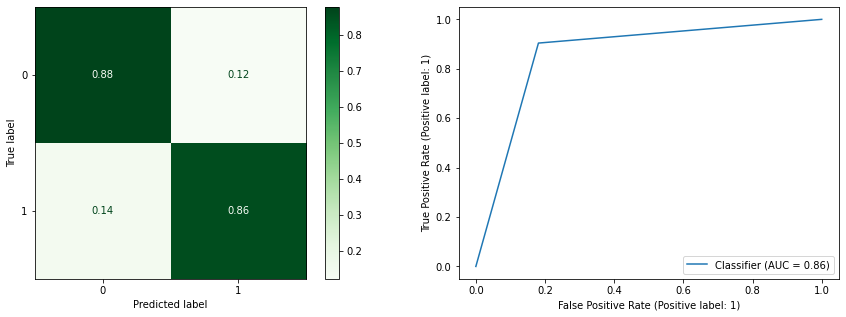

None
CPU times: user 707 ms, sys: 90.4 ms, total: 798 ms
Wall time: 699 ms


In [336]:
%%time
best_log_reg_pipe.fit(X2_train, y2_train)
print(f'Accuracy of best Gradient boosting model is: {best_log_reg_pipe.score(X2_test, y2_test)}')
print('\n')

#Save predictions to run through evaluate_classification function
log_reg2_best_params_train_pred = best_log_reg_pipe.predict(X2_train)
log_reg2_best_params_test_pred = best_log_reg_pipe.predict(X2_test)

print(evaluate_classification(log_reg_best_params_test_pred ,y_test,label = 'Logistic Regression metrics - Tuned'))
print(evaluate_classification(log_reg2_best_params_test_pred ,y2_test,label = 'Logistic Regression metrics - Tuned + Feature engineering'))

After applying feature engineering to the dataset used for the Logistic Regression model, overall metrics remain unchanged.

I would choose the default XGBoost model for my "production" model as it performs the best in terms of accuracy, precision, recall, and AUC.